## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
from model_scripts.feature_extraction import *
from model_scripts.executions import *
import torch.nn.functional as F
from Experimentation.expt_scripts.sugarcontent_data_processing import *
from Experimentation.expt_scripts.expt_plots import *
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.regression import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset Prep: B10 for Baselines

### Load data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)
Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

Here only the train data is used, since we have sugarcontent ground truths only for the train set. We divide this data into train and test again for calculating RMSE.

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1491, 4, 10, 64, 64]), torch.Size([33, 4, 10, 64, 64]))

Create Sub-Patches

In [5]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([50529, 4, 10, 4, 4]), torch.Size([1213, 4, 10, 4, 4]))

Get properly formatted field numbers

In [6]:
train_coord_fn = get_string_fielddata(train_subpatch_coords)
eval_coord_fn = get_string_fielddata(eval_subpatch_coords)
eval_coord_fn[0]

'1615767.0_12_20'

## 1. K-means flattened Images

In [25]:
#comment the below line when loading saved model
kmeans = kmeans_function(train_subpatches, n_clusters=2, random_state=101)    

train_subpatch_predictions = kmeans.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
eval_subpatch_predictions = kmeans.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

In [26]:
np.unique(eval_subpatch_predictions, return_counts=True)

(array([0, 1], dtype=int32), array([1022,  191]))

Clustering Accuracy: Convert sub-patch level labels to patch-level labels and compare with ground truth

In [27]:
# disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold, 'Flattened Data', True) #for saving predictions
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 85.0
Precision: 87.18
Recall: 97.14
F1-score: 91.89
F2-score: 94.97


## 2. Histogram Features

### Feature extraction 

In [9]:
histogram_features_train = extract_global_histogram(train_subpatches, bins=30)
histogram_features_eval = extract_global_histogram(eval_subpatches, bins=30)
histogram_features_train.shape, histogram_features_eval.shape # (N, T * C * bins)

((50529, 30), (1213, 30))

In [20]:
#comment the below line when loading saved model
kmeans_hist = kmeans_function(histogram_features_train, n_clusters=2, random_state=102)

train_subpatch_predictions = kmeans_hist.predict(histogram_features_train.reshape(histogram_features_train.shape[0],-1))
eval_subpatch_predictions = kmeans_hist.predict(histogram_features_eval.reshape(histogram_features_eval.shape[0],-1))

Clustering Accuracy: Convert sub-patch level labels to patch-level labels and compare with ground truth

In [24]:
# disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold, 'Flattened Data', True) #for saving predictions
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 85.0
Precision: 87.18
Recall: 97.14
F1-score: 91.89
F2-score: 94.97


In [16]:
np.unique(eval_subpatch_predictions, return_counts=True)

(array([0, 1], dtype=int32), array([1013,  200]))

## 3. Conv2D Autoencoders

In [28]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed

### Data Loader for Autoencoders

In [29]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_fn, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_fn, batch_size=config.ae_batch_size, shuffle=False)

### Load Trained Models and Extract Features

In [ ]:
device = 'cuda'
epochs = 50
lr = 0.01
latent_dim=32
channels = 10
optimizer = 'SGD'
momentum = 0.9
time_steps = config.temporal_stack_size_2024
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(40, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [31]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

In [32]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, temp_embed_pixel=False, device=device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, temp_embed_pixel=False, device=device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=False, device=device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [33]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=103)    # Skip this when loading saved model

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [35]:
np.unique(eval_subpatch_predictions, return_counts=True)

(array([0, 1], dtype=int32), array([1004,  209]))

In [34]:
# disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold, '2D_AE', True)  #for saving predictions
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 77.5
Precision: 86.11
Recall: 88.57
F1-score: 87.32
F2-score: 88.07


## Data Prep: 3D_AE_B10 with encodings

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [10]:
# preprocessing_pipeline = PreProcessingPipelineTemporal()

# preprocessing_pipeline.run_temporal_patch_save_pipeline(type='train')
# preprocessing_pipeline.run_temporal_patch_save_pipeline(type='eval')

Load Patches

In [36]:
preprocessing_pipeline = PreProcessingPipelineTemporal()

field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10_add', method='sin-cos',data_year='2024')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10_add', method='sin-cos', data_year='2024')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1491, 4, 10, 64, 64]), torch.Size([33, 4, 10, 64, 64]))

Create Sub-Patches

In [37]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([50529, 4, 10, 4, 4]), torch.Size([1213, 4, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [38]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1615767.0_12_20', 1213, 50529)

Split Unlabeled data into 'train' and 'test' and create  Data Loaders


The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [39]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Model prep: 3D_AE_B10 with encodings

### Load saved 3D Conv Autoencoder trained with temporal data
Redefine the architecture because the object needs to be created to load saved checkpoints

In [40]:
class Conv3DAutoencoder_Time_Addition(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder_Time_Addition, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings_tensor.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [41]:
device = 'cuda'
epochs = 50
momentum=0.9
lr = 0.001
vae_lr=0.001
latent_dim = 32
channels = 10
time_steps = 4
optimizer = 'Adam'
vae_optimizer = 'Adam'
patch_size = config.subpatch_size

In [ ]:
model_names = ["3D_AE_temporal_addition_2024"]
model_objs = [Conv3DAutoencoder_Time_Addition]  
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        dataloader_eval=dataloader_eval,
        channels=channels,
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path
    )
    print("Model ",name," trained")


Model  3D_AE_temporal_addition_2024  trained


### Results

In [45]:
model_names = ['3D_AE_temporal_addition', "3D_AE_temporal_addition_2024"]
df_loss, df_accuracy, df_recall, df_f1, df_precision = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

### F1-paper

In [46]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333
1,3D_AE_temporal_addition_2024,88.89,84.06,88.89,87.280000


In [47]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,3D_AE_temporal_addition,68.85,68.85,70.49,69.396667
1,3D_AE_temporal_addition_2024,80.00,72.50,80.00,77.500000


In [48]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333
1,3D_AE_temporal_addition_2024,91.43,82.86,91.43,88.573333


In [49]:
df_precision

,Model,Precision Run 1,Precision Run 2,Precision Run 3,Precision Avg
0,3D_AE_temporal_addition,69.05,69.05,72.97,70.356667
1,3D_AE_temporal_addition_2024,86.49,85.29,86.49,86.090000


## 2019 vs 2024 plot

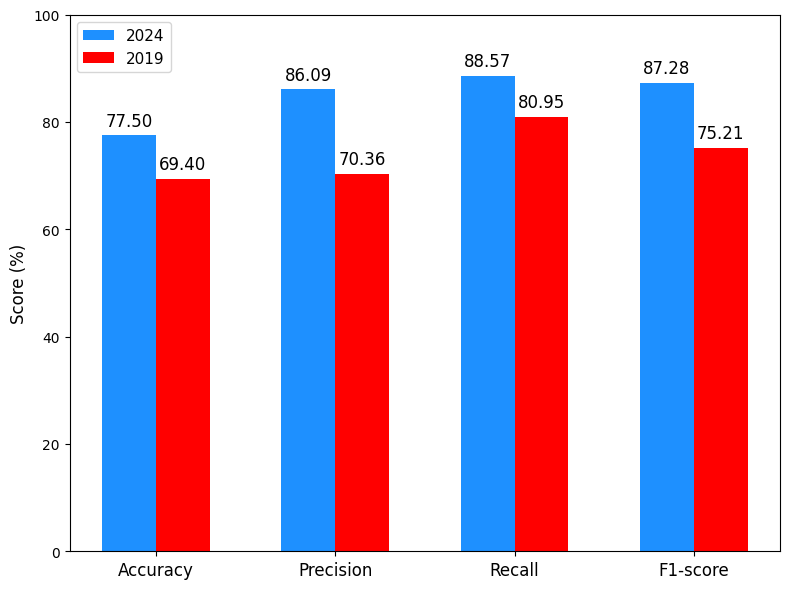

In [5]:
plot_2019_vs_2024()